**Name :- Kantariya Manthan Jayendra**

**EnrollMent No :- 18012011032**

**Subject :- Deep Learning**

**Definition :- Weather Analysis using CNN**


### 1.Download Weather Data

In [1]:
import os
import shutil
def load_Data():
  os.system('gdown https://drive.google.com/u/3/uc?id=1VmG3JJxqeipRhbIt-O0E92r1nDuj7P9z')
  os.makedirs("dataset", exist_ok = True)
  shutil.unpack_archive('/content/weather_data.zip','/content/dataset/')

In [2]:
load_Data()

### 2.Import Libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, model_from_json, Sequential
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
# from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

import pandas as pd
from skimage.io import imread, imsave
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(2021)

In [4]:
### Path of images
train_path = '/content/dataset/'

### 3.Total Images

In [5]:
import glob
for i in glob.glob('/content/dataset/*'):
  print(f"Count : ", len(glob.glob(f'{i}/*')))

len(glob.glob('/content/dataset/*/*'))

Count :  253
Count :  357
Count :  215
Count :  300


1125

### 4.Visualize the data

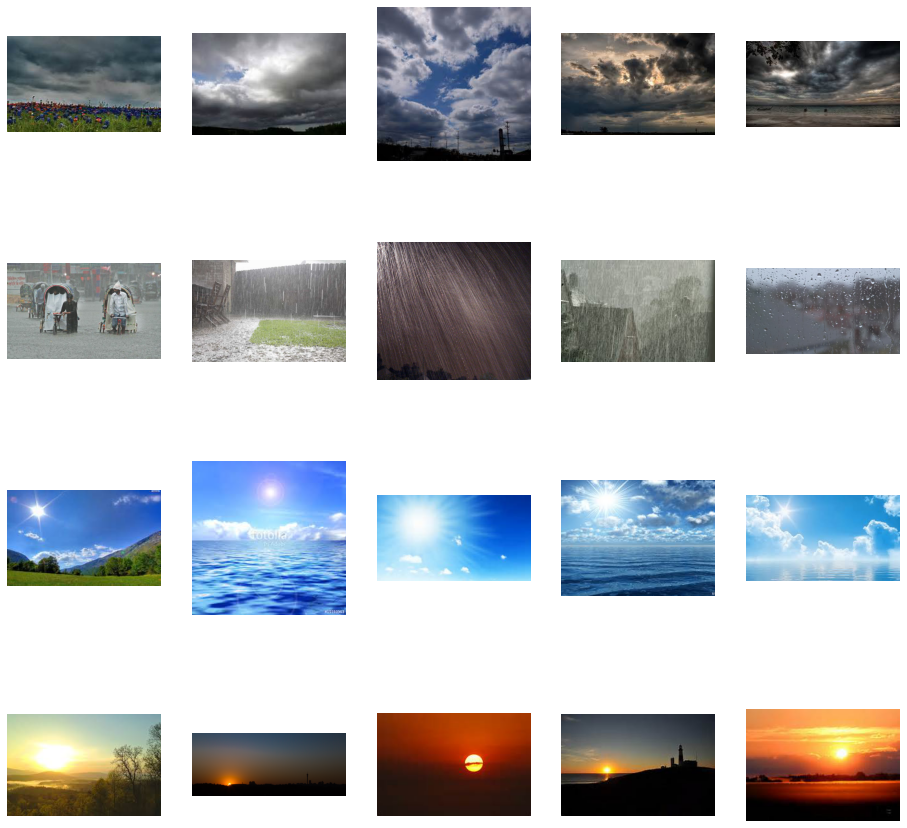

In [6]:
# 1.simple visualization
sample_images = []

# 2.Get all subdirs
subdirs = sorted(os.listdir(train_path))
# subdirs = [x for x in subdirs if "DS_Store" not in x]

# 3.Get samples
for subdir in subdirs:
    images = os.listdir(f"{train_path}/{subdir}")
    # print(images)
    random_images_idx = np.random.choice(len(images), 5)
    for idx in random_images_idx:
        img = imread(f"{train_path}/{subdir}/{images[idx]}")
        sample_images.append(img)

# 4.Plot samples
f,ax = plt.subplots(4, 5, figsize=(16,16))

for i, img in enumerate(sample_images):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis("off")
plt.show() # simple visualization

### 5.Preprocessing Data Function

In [7]:
def preprocessing_img(instancePath):
    image = load_img(instancePath, target_size=(256, 256))
    image = img_to_array(image)
    image /= 255.0
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image

### 6.Train data prepare

In [8]:
from sklearn.metrics import *
from sklearn import preprocessing

In [9]:
def prepare_train_data(instance_path):
  X_train = []
  y_train = []

  for class_folder_name in os.listdir(instance_path):
    print(f"{class_folder_name}")
    class_folder_path = os.path.join(instance_path, class_folder_name)
    for img in tqdm(os.listdir(class_folder_path)):
      imgpath = os.path.join(class_folder_path, img)
      img = preprocessing_img(imgpath)
      X_train.append(img)
      y_train.append(class_folder_name)

  X_train = np.asarray(X_train)
  y_train = np.asarray(y_train)
  
  # Label Encoding
  le = preprocessing.LabelEncoder()
  y_train = le.fit_transform(y_train)

  # print the result classes and unique labels numbers
  print(le.classes_)
  print(np.unique(y_train))   

  # Generate the mapping dictonary
  class_mapping = {}
  for i,z in zip(le.classes_, list(np.unique(y_train))):
    class_mapping[z] = i

  print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')
  nb_classes = len(np.unique(y_train))
  return X_train,y_train, nb_classes, class_mapping

### 7.Load the dataset in X and Y format

In [10]:
X,y, nb_classes, class_mapping = prepare_train_data(train_path)

shine


  0%|          | 0/253 [00:00<?, ?it/s]

sunrise


  0%|          | 0/357 [00:00<?, ?it/s]

rain


  0%|          | 0/215 [00:00<?, ?it/s]

cloudy


  0%|          | 0/300 [00:00<?, ?it/s]

['cloudy' 'rain' 'shine' 'sunrise']
[0 1 2 3]
X_train shape:(1125, 256, 256, 3)
Y_train shape:(1125,)


### 8.Convert Target into one hot encoding

In [11]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 4)
print(f'X_train shape:{X.shape}\nY_train shape:{y.shape}')

X_train shape:(1125, 256, 256, 3)
Y_train shape:(1125, 4)


### 9.Split data into train and test split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 10.Print the Shape of train and test

In [13]:
data, name = [X_train, X_test, y_train, y_test], ["X_train","X_test","y_train","y_test"]
for i, n in zip(data, name):
  print(f"{n} : {i.shape}")
  

X_train : (900, 256, 256, 3)
X_test : (225, 256, 256, 3)
y_train : (900, 4)
y_test : (225, 4)


### 11.Model Design CNN Model Architecture

In [14]:
def CNN(input_shape = (256,256,3), nClasses = nb_classes):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(2, 2))
  
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  
  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(nClasses, activation='softmax'))
  display(model.summary())
  return model

### 12.Load The Model and Print the architecture

In [15]:
# del model
model = CNN()
sgd = SGD(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        3

None

### 13.Visualization CNN Model

In [16]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 9.3 MB/s 


In [17]:
import visualkeras

In [18]:
help(visualkeras.layered_view)

Help on function layered_view in module visualkeras.layered:

layered_view(model, to_file: str = None, min_z: int = 20, min_xy: int = 20, max_z: int = 400, max_xy: int = 2000, scale_z: float = 0.1, scale_xy: float = 4, type_ignore: list = None, index_ignore: list = None, color_map: dict = None, one_dim_orientation: str = 'z', background_fill: Any = 'white', draw_volume: bool = True, padding: int = 10, spacing: int = 10, draw_funnel: bool = True, shade_step=10, legend: bool = False, font: <module 'PIL.ImageFont' from '/usr/local/lib/python3.7/dist-packages/PIL/ImageFont.py'> = None, font_color: Any = 'black') -> <module 'PIL.Image' from '/usr/local/lib/python3.7/dist-packages/PIL/Image.py'>
    Generates a architecture visualization for a given linear keras model (i.e. one input and output tensor for each
    layer) in layered style (great for CNN).
    
    :param model: A keras model that will be visualized.
    :param to_file: Path to the file to write the created image to. If the im

### **14.Convolution Neural Network Architecture Figure**

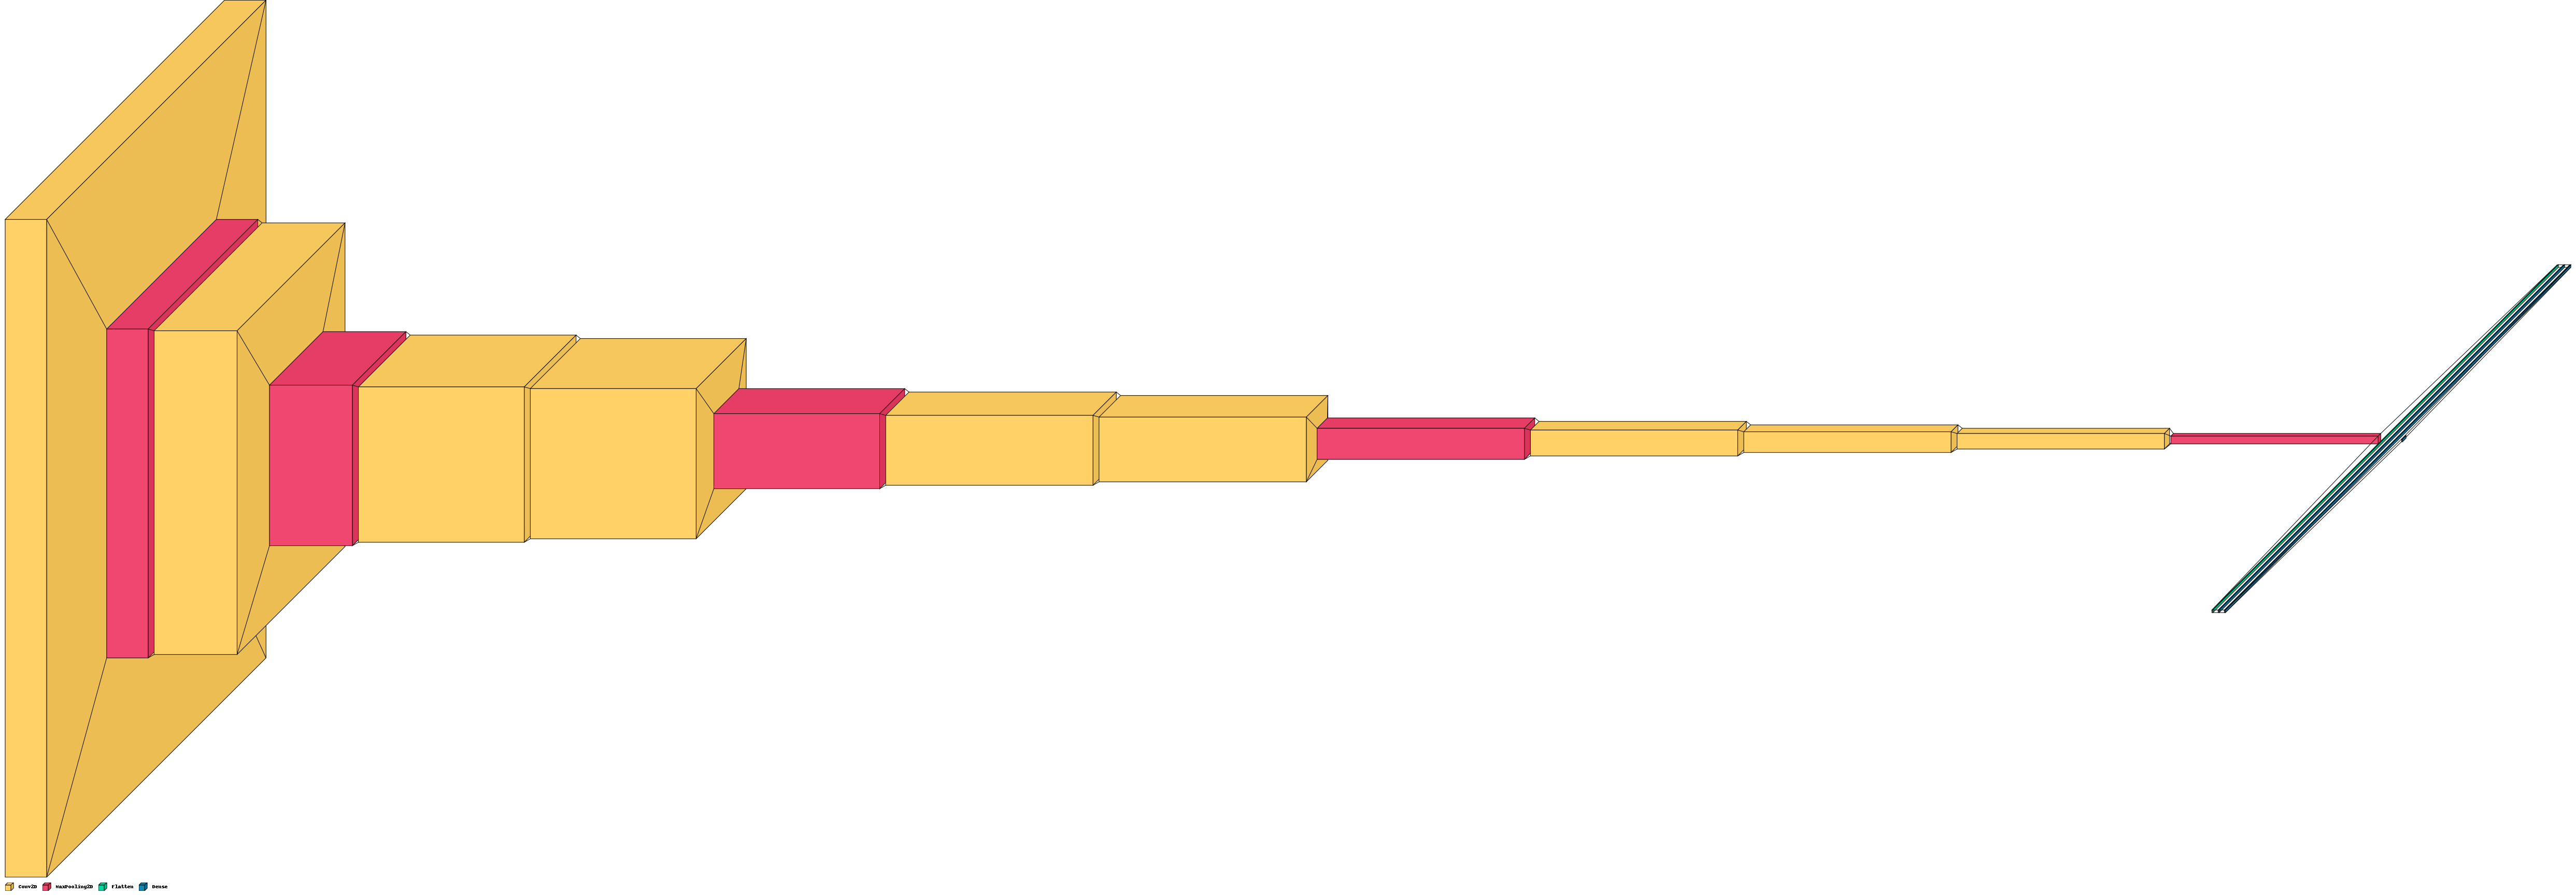

In [19]:
visualkeras.layered_view(model, legend=True, min_xy=5, min_z=2, scale_xy=5, scale_z=5, one_dim_orientation='x')

In [20]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    steps_per_epoch=len(X_train)//16,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test)//16,  # 1000 images = batch_size * steps
                    verbose=1)

Epoch 1/20
56/56 [==============================] - 84s 1s/step - loss: 1.3867 - accuracy: 0.1908 - val_loss: 1.3869 - val_accuracy: 0.1875
Epoch 2/20
56/56 [==============================] - 79s 1s/step - loss: 1.3862 - accuracy: 0.1968 - val_loss: 1.3866 - val_accuracy: 0.1875
Epoch 3/20
56/56 [==============================] - 81s 1s/step - loss: 1.3862 - accuracy: 0.1878 - val_loss: 1.3863 - val_accuracy: 0.1875
Epoch 4/20
56/56 [==============================] - 80s 1s/step - loss: 1.3860 - accuracy: 0.1968 - val_loss: 1.3861 - val_accuracy: 0.1875
Epoch 5/20
56/56 [==============================] - 80s 1s/step - loss: 1.3856 - accuracy: 0.1867 - val_loss: 1.3858 - val_accuracy: 0.1875
Epoch 6/20
56/56 [==============================] - 81s 1s/step - loss: 1.3856 - accuracy: 0.1957 - val_loss: 1.3856 - val_accuracy: 0.1875
Epoch 7/20
56/56 [==============================] - 81s 1s/step - loss: 1.3853 - accuracy: 0.2986 - val_loss: 1.3853 - val_accuracy: 0.3527
Epoch 8/20
56/56 [==

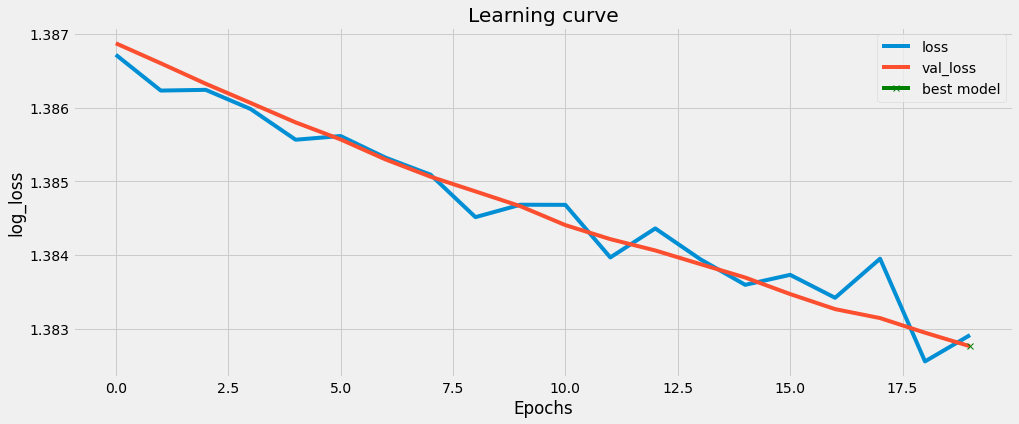

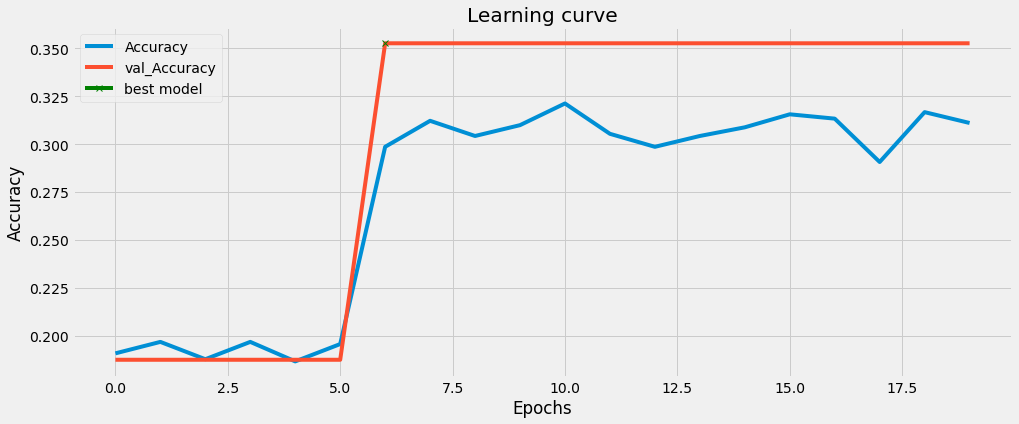

In [21]:
  plt.style.use("fivethirtyeight")
  plt.figure(figsize = (15,6))
  plt.title("Learning curve")
  plt.plot(model.history.history["loss"], label="loss")
  plt.plot(model.history.history["val_loss"], label="val_loss")
  plt.plot(tf.argmin(model.history.history["val_loss"]), min(model.history.history["val_loss"]), marker="x", color="g", label="best model")
  plt.xlabel("Epochs")
  plt.ylabel("log_loss")
  plt.legend();

  plt.figure(figsize = (15,6))
  plt.title("Learning curve")
  plt.plot(model.history.history["accuracy"], label="Accuracy")
  plt.plot(model.history.history["val_accuracy"], label="val_Accuracy")
  plt.plot(tf.argmax(model.history.history["val_accuracy"]), max(model.history.history["val_accuracy"]), marker="x", color="g", label="best model")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend();

### 15.Transfer learning

In [22]:
tf.keras.backend.clear_session()

def ResNet50v2(input_shape = (256,256,3), train_whole_network = True, nClasses = nb_classes):
  image_input = Input(shape=input_shape)

  # Transfer Learning
  resnet = ResNet50V2(input_tensor=image_input, include_top=False, weights='imagenet')
  resnet.trainable = train_whole_network
  resnet_last_layer = resnet.output

  # Global Max Pooling 2d for connect to Transfer learning
  x = GlobalMaxPool2D()(resnet_last_layer)
  x = Dropout(0.25)(x)
  x= Flatten(name='flatten')(x)

  # Output Layer
  out = Dense(nb_classes, activation='softmax', name='output_layer')(x)
  model = Model(inputs=image_input,outputs= out)
  display(model.summary())
  return model

### 16.Load Transfer Learning Model

In [23]:
# del resnet
resnet = ResNet50v2()
adam = Adam(lr=0.0001)
resnet.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

None

### 17.Transfer learing Model Visualization

In [24]:
# visualkeras.layered_view(resnet, legend=True, min_xy=10, min_z=10, scale_xy=10, scale_z=10)

In [25]:
best_model = ModelCheckpoint("resnet.h5", monitor='val_accuracy', verbose = 1, save_best_only = True)

In [26]:
history_resnet = resnet.fit(X_train, y_train,
                    batch_size = 16,
                    steps_per_epoch=len(X_train)//16,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test)//16,  # 1000 images = batch_size * steps
                    verbose=1,
                    callbacks = [best_model])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 3.2463 - accuracy: 0.6663
Epoch 00001: val_accuracy improved from -inf to 0.35268, saving model to resnet.h5
56/56 [==============================] - 571s 10s/step - loss: 3.2463 - accuracy: 0.6663 - val_loss: 3.5347 - val_accuracy: 0.3527
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.4415 - accuracy: 0.8281
Epoch 00002: val_accuracy did not improve from 0.35268
56/56 [==============================] - 561s 10s/step - loss: 1.4415 - accuracy: 0.8281 - val_loss: 2.1434 - val_accuracy: 0.3527
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.2689 - accuracy: 0.8394
Epoch 00003: val_accuracy did not improve from 0.35268
56/56 [==============================] - 551s 10s/step - loss: 1.2689 - accuracy: 0.8394 - val_loss: 3.0853 - val_accuracy: 0.2321
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 0.8517 - accuracy: 0.8801
Epoch 00004: val_accuracy did not impr

In [27]:
# resnet.load_weights("/content/resnet.h5")
resnet.evaluate(X_test, y_test)

8/8 [==============================] - 31s 4s/step - loss: 3.3057 - accuracy: 0.5733


[3.305720329284668, 0.5733333230018616]

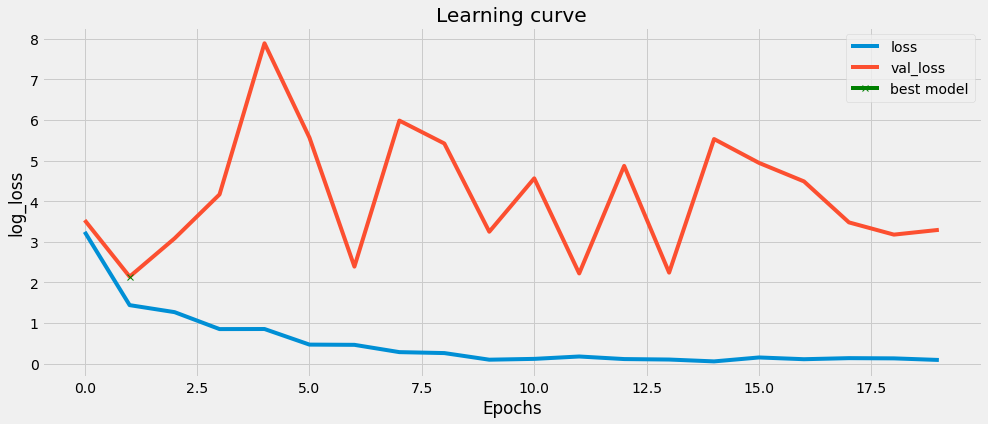

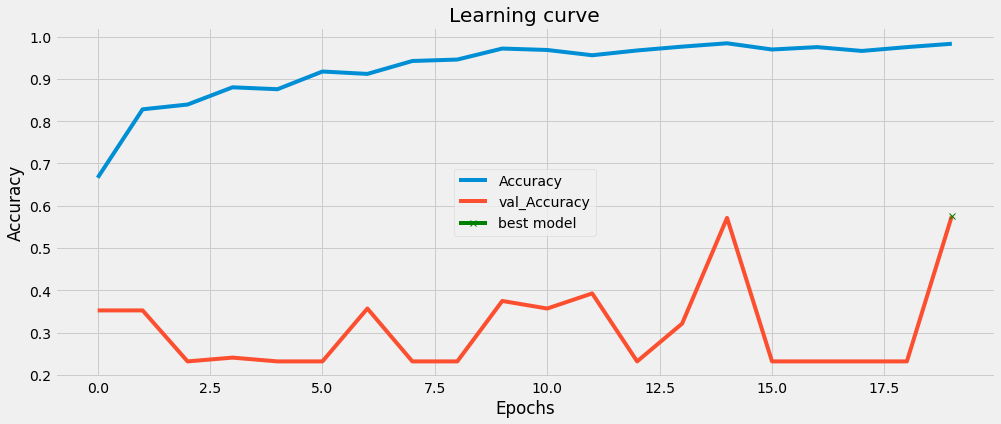

In [28]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(history_resnet.history["loss"], label="loss")
plt.plot(history_resnet.history["val_loss"], label="val_loss")
plt.plot(tf.argmin(history_resnet.history["val_loss"]), min(history_resnet.history["val_loss"]), marker="x", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(history_resnet.history["accuracy"], label="Accuracy")
plt.plot(history_resnet.history["val_accuracy"], label="val_Accuracy")
plt.plot(tf.argmax(history_resnet.history["val_accuracy"]), max(history_resnet.history["val_accuracy"]), marker="x", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
plt.show()

### 18.Result Prediction

8/8 [==============================] - 31s 4s/step - loss: 3.3057 - accuracy: 0.5733
Validation Accuracy : 0.5733333230018616
Validation Loss: 3.305720329284668 
8/8 [==============================] - 32s 4s/step
-------------------------
Cohen Kappa : 0.39400740657614175
-------------------------
Confusion Matrix
[[ 0  0 30 22]
 [ 0  4 18 20]
 [ 0  0 48  4]
 [ 0  0  2 77]]


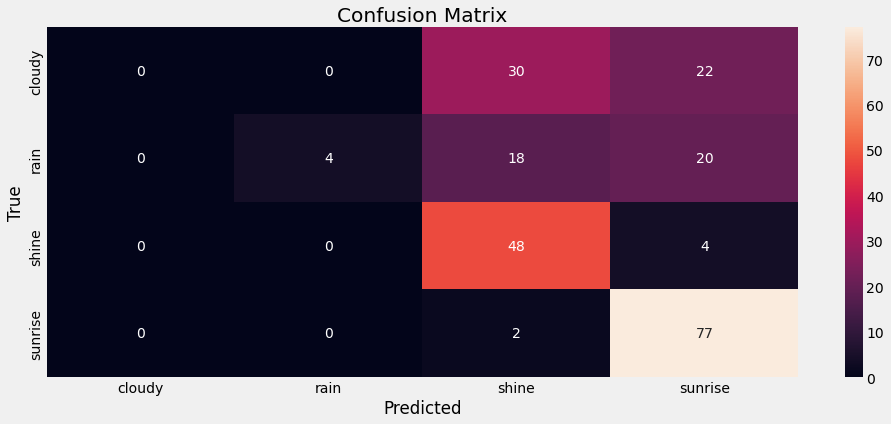

Classification Report
              precision    recall  f1-score   support

      cloudy       0.00      0.00      0.00        52
        rain       1.00      0.10      0.17        42
       shine       0.49      0.92      0.64        52
     sunrise       0.63      0.97      0.76        79

    accuracy                           0.57       225
   macro avg       0.53      0.50      0.39       225
weighted avg       0.52      0.57      0.45       225



In [29]:
loss, accuracy = resnet.evaluate(X_test,y_test)
print(f"Validation Accuracy : {accuracy}\nValidation Loss: {loss} ")

#Confution Matrix and Classification Report
y_pred = np.argmax(resnet.predict(X_test, verbose=1), axis=1)
y_test = np.argmax(y_test, axis=1)

print("-"*25)
print(f"Cohen Kappa : {cohen_kappa_score(y_test, y_pred)}")

print("-"*25)

import seaborn as sns
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
print(cm)
labels = list(class_mapping.values())

plt.figure(figsize=(15,6))
sns.heatmap(cm, annot=True,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print('Classification Report')
print(classification_report(y_test, y_pred, target_names=labels, zero_division=0))